## JTSS APT setup

### This notebook details how to set up the JTSS observations in the APT, using the custom hMPT code to override shutters

#### Some questions: what are the dh_select=0 sources? Should we still be randomly downsampling the z<2 sources? do we need the flux information in the target catalogs in APT? Is M or H for bright/faint? Are we doing unconstrained?

In [83]:
import numpy as np
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
import pandas as pd

import msa_planner
import importlib
importlib.reload(msa_planner)

<module 'msa_planner' from '/home/smmccrty/Research/JWST/hMPT/msa_planner.py'>

In [57]:
# read in catalogs, standardize column names, and stack. Ignoring flux columns here.
JTSS_catalog_GN = Table.read('jtss_data/JTSS_catalog_GN_v4.fits')['ID','RA','DEC','z_a','dh_select']
JTSS_catalog_GS = Table.read('jtss_data/JTSS_catalog_GS_v4.fits')['ID','RA','DEC','z_a','dh_select']
JTSS_catalog_UNCOVER = Table.read('jtss_data/JTSS_catalog_UNCOVER_v4.fits')['id','ra','dec','z_phot','dh_select']
JTSS_catalog_UNCOVER.rename_columns(JTSS_catalog_UNCOVER.colnames, JTSS_catalog_GN.colnames)  # ensure same column names
JTSS_master_catalog = vstack([JTSS_catalog_GN, JTSS_catalog_GS, JTSS_catalog_UNCOVER])

In [58]:
# read in pointings
final_pointings = np.zeros((7,4,3,3)) # 7 tiles, 4 pointings per tile, 3 dithers per pointing, 3 values (RA, Dec, V3PA)

with open('jtss_data/pointings', 'r') as f:
    lines = f.readlines()
    current_tile = 0
    current_pointing = 0
    current_dither = 0
    for i, line in enumerate(lines):
        if line == '\n':
            current_tile += 1
            current_pointing = 0
            current_dither = 0
            continue
        else:
            parts = line.split()
            final_pointings[current_tile, current_pointing, current_dither] = [float(parts[1]), float(parts[2]), float(parts[3])]
            current_dither += 1
            if current_dither == 3:
                current_pointing += 1
                current_dither = 0

##### Function to create catalogs for each tile, mitigating the EoE

In [59]:
def create_tile_catalog(master_catalog, tile, radius=0.5, downsample_lowz=True, random_seed=42):
    """
    Create a catalog for a specific tile by selecting objects within the tile's footprint
    and adding fake objects to ensure the median coord is the center of the tile for the EoE.

    Radius is in degrees. Default is 0.5 deg (1 deg diameter). This can be adjusted as needed.
    """
    np.random.seed(random_seed)

    center = [tile[:,:,0].mean(), tile[:, :, 1].mean()] # could do median or pick one of the pointings or whatever
    center_coord = SkyCoord(ra=center[0], dec=center[1], unit='deg')

    catalog_coords = SkyCoord(ra=master_catalog['RA'], dec=master_catalog['DEC'], unit='deg')
    separations = center_coord.separation(catalog_coords).deg
    mask = separations <= radius
    catalog = master_catalog[mask]

    if downsample_lowz:
        mask = catalog['z_a'] < 2
        rows_to_downsample = np.where(mask)[0]
        downsampled_indices = np.random.choice(rows_to_downsample,
                                            size=len(rows_to_downsample)//3,
                                            replace=False)
        rows_to_keep = np.where(~mask)[0]
        final_indices = np.sort(np.concatenate([downsampled_indices, rows_to_keep]))
        catalog = catalog[final_indices]

    # Now pad to ensure the median RA/Dec is exactly the center. This may not be that nessecary if we already filtered in a small circle.
    padded_catalog = msa_planner.create_padded_catalog(catalog, center)

    print(f"Tile center: RA={center[0]:.4f}, Dec={center[1]:.4f}\nCatalog center: RA={np.median(padded_catalog['RA']):.4f}, Dec={np.median(padded_catalog['DEC']):.4f}" +
          f"\nNumber of objects in catalog (before/after padding): {len(catalog)}/{len(padded_catalog)}")

    return padded_catalog

In [60]:
# create the catalogs and save as CSVs for APT. APT requires a '#' before the header line to read it properly so this is done manually.
for t,tile in enumerate(final_pointings):
    catalog = create_tile_catalog(JTSS_master_catalog, tile, radius=0.5, downsample_lowz=True, random_seed=42)
    with open(f'jtss_data/tile_{t:}_catalog.csv', 'w') as f:
        f.write('# ID,RA,DEC,Redshift,Number\n')  # APT recognizes 'Number' instead of dh_select and Redshift instead of z_a
        catalog.to_pandas().to_csv(f, index=False, header=False)

Tile center: RA=52.9900, Dec=-27.8150
Catalog center: RA=52.9900, Dec=-27.8150
Number of objects in catalog (before/after padding): 66515/114140
Tile center: RA=53.0560, Dec=-27.8818
Catalog center: RA=53.0560, Dec=-27.8818
Number of objects in catalog (before/after padding): 66515/132414
Tile center: RA=53.1150, Dec=-27.8350
Catalog center: RA=53.1150, Dec=-27.8350
Number of objects in catalog (before/after padding): 66515/107182
Tile center: RA=53.1603, Dec=-27.7781
Catalog center: RA=53.1603, Dec=-27.7781
Number of objects in catalog (before/after padding): 66515/142540
Tile center: RA=189.2700, Dec=62.1800
Catalog center: RA=189.2700, Dec=62.1800
Number of objects in catalog (before/after padding): 37763/65370
Tile center: RA=189.2068, Dec=62.2323
Catalog center: RA=189.2068, Dec=62.2323
Number of objects in catalog (before/after padding): 37763/58804
Tile center: RA=3.5800, Dec=-30.3800
Catalog center: RA=3.5800, Dec=-30.3800
Number of objects in catalog (before/after padding): 23

In [61]:
# print everything out for copying into APT
for t,tile in enumerate(final_pointings):
    print(f"Coords for tile {t}:")
    for p,pointing in enumerate(tile):
        print(f'Pointing {p}')
        for d,dither in enumerate(pointing):
            print(f'Dither {d}: RA={dither[0]}, Dec={dither[1]}, APA={(dither[2]+180-41.42543)%360}')

    print('\n')

Coords for tile 0:
Pointing 0
Dither 0: RA=52.9753458, Dec=-27.806397, APA=78.57457
Dither 1: RA=52.97560197, Dec=-27.80652836, APA=78.57457
Dither 2: RA=52.97508964, Dec=-27.80626564, APA=78.57457
Pointing 1
Dither 0: RA=52.99972685, Dec=-27.80203897, APA=78.57457
Dither 1: RA=52.99998301, Dec=-27.80217032, APA=78.57457
Dither 2: RA=52.9994707, Dec=-27.80190761, APA=78.57457
Pointing 2
Dither 0: RA=52.98027315, Dec=-27.82796103, APA=80.57457
Dither 1: RA=52.98052402, Dec=-27.82810022, APA=80.57457
Dither 2: RA=52.98002227, Dec=-27.82782185, APA=80.57457
Pointing 3
Dither 0: RA=53.0046542, Dec=-27.823603, APA=80.57457
Dither 1: RA=53.00490506, Dec=-27.82374219, APA=80.57457
Dither 2: RA=53.00440333, Dec=-27.82346382, APA=80.57457


Coords for tile 1:
Pointing 0
Dither 0: RA=53.0413536, Dec=-27.87315505, APA=78.57457
Dither 1: RA=53.04160993, Dec=-27.87328641, APA=78.57457
Dither 2: RA=53.04109728, Dec=-27.87302369, APA=78.57457
Pointing 1
Dither 0: RA=53.06573465, Dec=-27.86879702, APA

#### Now, some button clicking in APT

- Targets -> Import MSA source catalog -> tile_X_catalog.csv
- Click tile_X_catalog.csv on the left -> New Candidate Set
- Name = tile_X_faint -> Add filter -> New number column filter -> min and max = 2, this selects Number (dh_select)=2 faint sources and excludes Number=3 fake sources
- Repeat for bright sample with min/max = 1, making sure to reclick tile_X_catalog before New Candidate Set so as not to make this a subset of tile_X_faint

- Now, -> MSA Planning Tool
- MSA catalogs = tile_X_catalog, Primary Candidate List = tile_X_faint, Filler Candidate List = None
- Enter APA for the first pointing
- 1 Shutter Slitler, Unconstrained
- Fixed pointings, enter three dithers
- Grating/Filters, select G395M/F290LP and G235M/F170LP
- Multiple sources per row, min seperation 4
- Allow sources in areas affected by stuck open shutters
- Plan name = tXpX_faint
- Generate plan
- Repeat but selecting Primary Candidate List = tile_X_bright and G395H/F290LP and G235H/F170LP

- Select "Plan"
- Ctrl select both bright and faint plans -> Create Observation
- Order them as desired
- Repeat x4 pointings per tile, x7 tiles, total of 28 obs

### Now creating custom MSA config files to import into APT
- We need to correct for the DVA, which requires knowing the theta parameter. At the moment, the only way to do this is to set up the observation in the APT as above and then File->Export->MSA target info-> search the xml file for theta. This can be skipped if theta is known. Also may not even matter at this stage.
- I have also downloaded the MSA Target Info files and a few of the MSA configuration files generated by MPT from the above in order to check consistency before overriding with our own config files

In [77]:
# For t0p0, theta = 69.30838038709697 deg
thetas = [69.30838038709697, 90, 90, 90, 90, 90, 90]

Tile 0, Pointing 0, Dither 0, Type faint
0 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


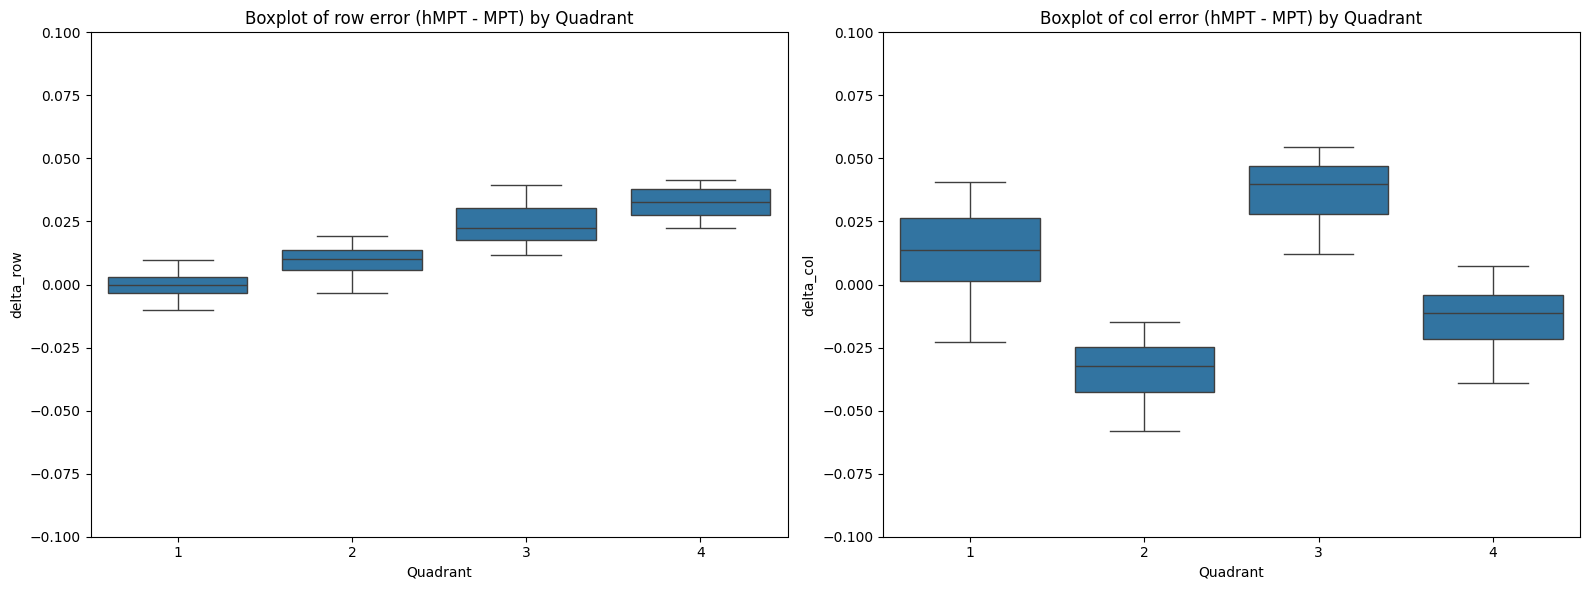

Tile 0, Pointing 0, Dither 0, Type bright
0 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


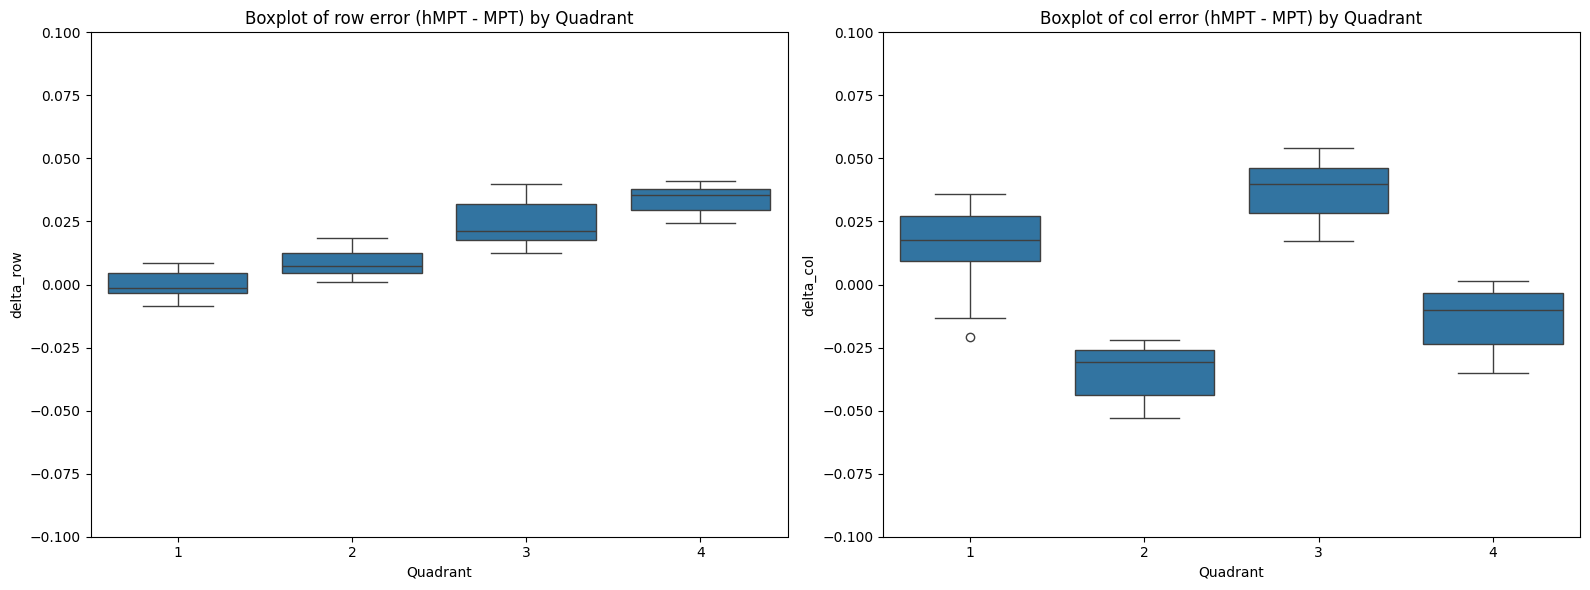

Tile 0, Pointing 0, Dither 1, Type faint
2 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


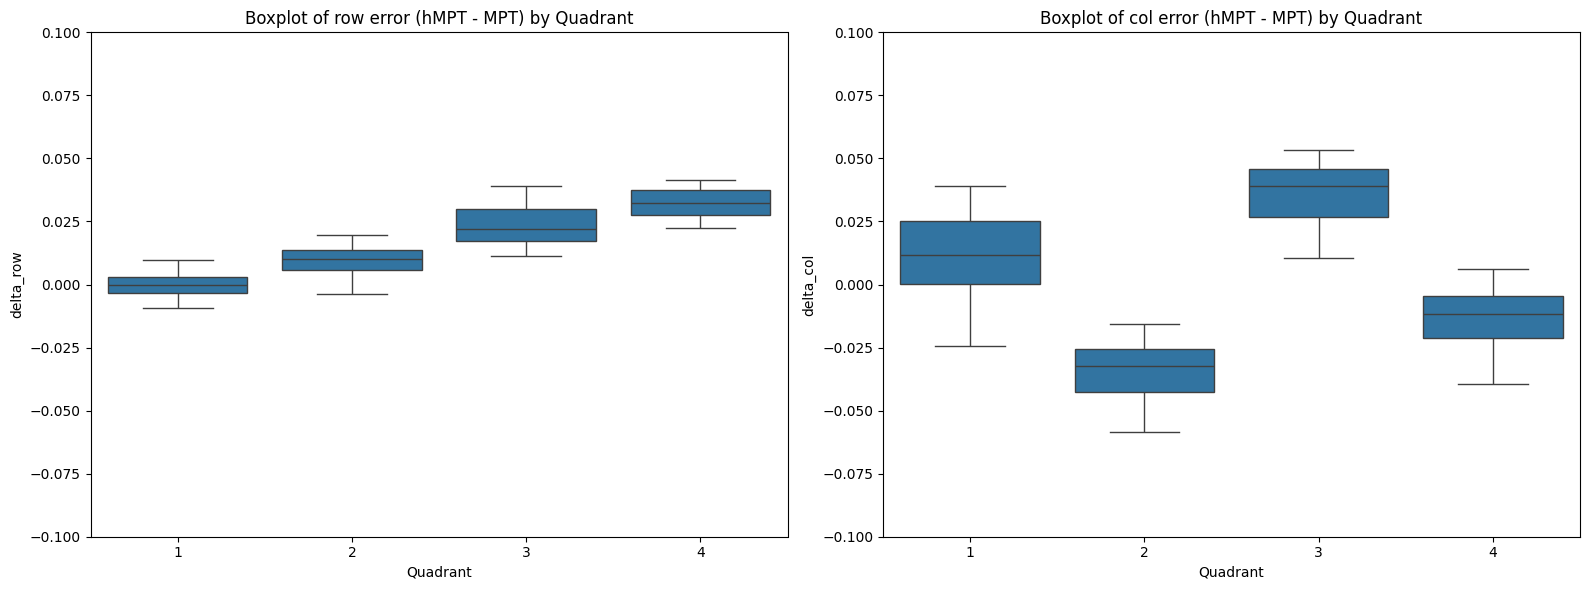

Tile 0, Pointing 0, Dither 1, Type bright
0 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


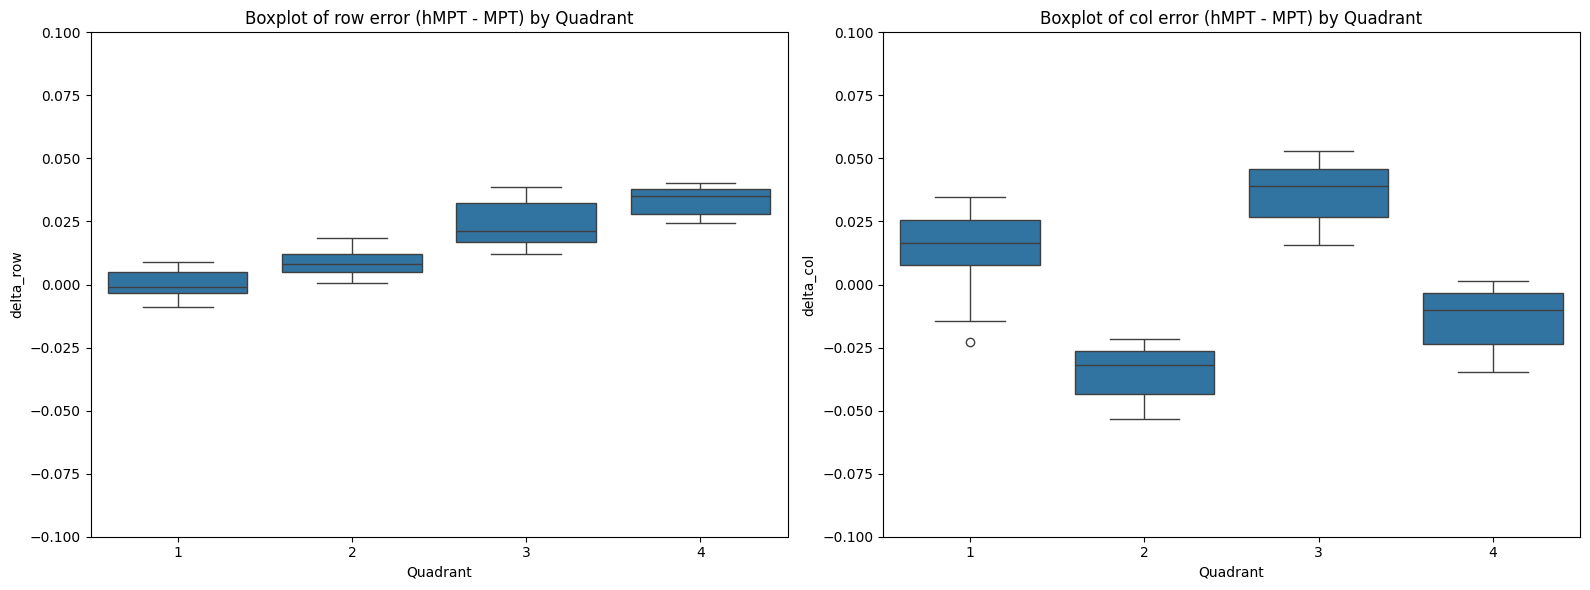

Tile 0, Pointing 0, Dither 2, Type faint
7 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


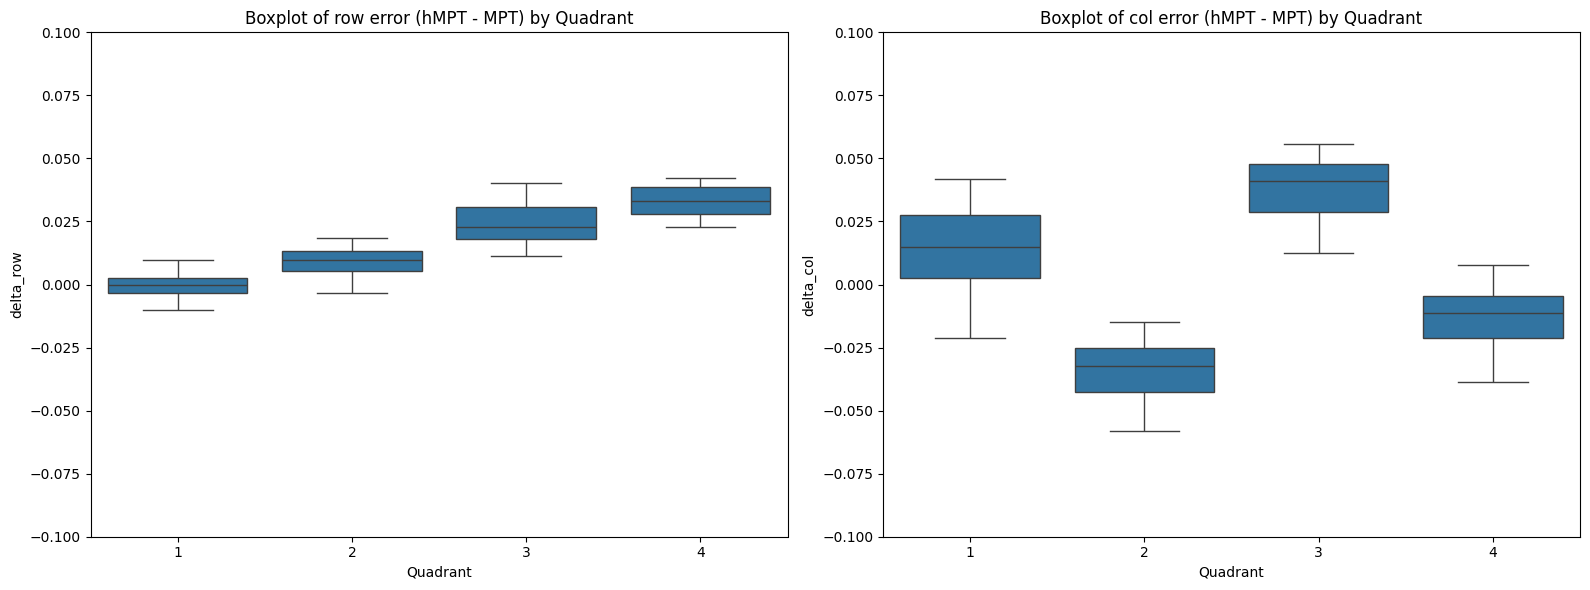

Tile 0, Pointing 0, Dither 2, Type bright
0 sources were marked out of bounds (quad<1)
0 quadrants are different between hMPT and MPT
0 sources were off by >0.5 in row
0 sources were off by >0.5 in col


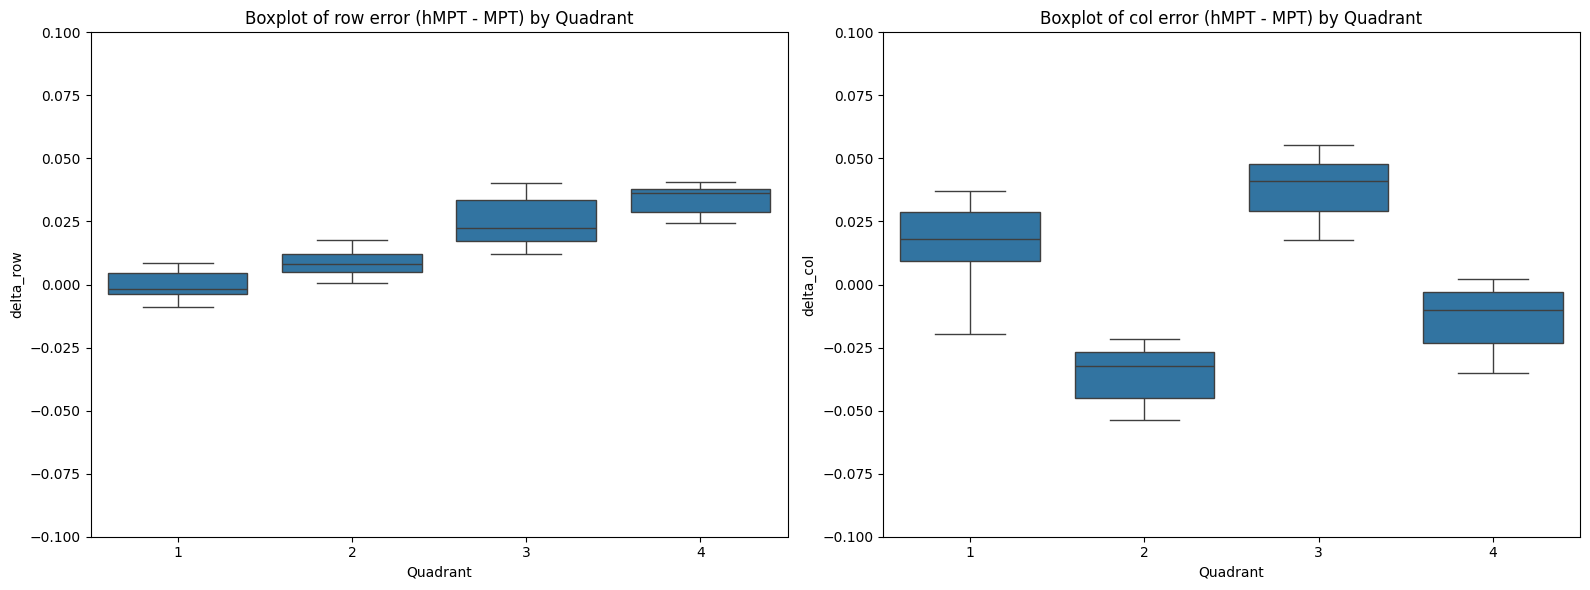

In [ ]:
import glob

for t, tile in enumerate(final_pointings[:1]): # just one for now
    catalog = pd.read_csv(f'jtss_data/tile_{t:}_catalog.csv', comment='#', names=['ID','RA','DEC','Redshift','Number'], index_col=False)
    faint_mask = catalog['Number'] == 2
    bright_mask = catalog['Number'] == 1
    MSAModel_faint = msa_planner.MSAModel(shutter_mask_file='esa_msa_map_APT_2025.5.3_v2.dat',
                                    distortion_file='msa_v2v3.dat',
                                    ra_sources = catalog['RA'][faint_mask].values,
                                    dec_sources = catalog['DEC'][faint_mask].values,
                                    buffer=msa_planner.UNCONSTRAINED)
    MSAModel_bright = msa_planner.MSAModel(shutter_mask_file='esa_msa_map_APT_2025.5.3_v2.dat',
                                    distortion_file='msa_v2v3.dat',
                                    ra_sources = catalog['RA'][bright_mask].values,
                                    dec_sources = catalog['DEC'][bright_mask].values,
                                    buffer=msa_planner.UNCONSTRAINED)
    
    for p, pointing in enumerate(tile[:1]): # just one for now
        for d, dither in enumerate(pointing):
            for type in ['faint','bright']:
                if type == 'faint':
                    MSAModel = MSAModel_faint
                else:
                    MSAModel = MSAModel_bright

                ra_msa, dec_msa, ang_v3 = dither
                theta = thetas[t]
                print(f'Tile {t}, Pointing {p}, Dither {d}, Type {type}')

                axy = msa_planner.radec_to_Axy(MSAModel.ra_sources, MSAModel.dec_sources, ra_msa, dec_msa, ang_v3, theta=theta)
                shutters = msa_planner.find_shutter_from_Axy(axy, MSAModel.spline_models)
                availible = MSAModel.apply_shutter_mask(shutters, MSAModel.shutter_mask)
                centered = MSAModel.apply_shutter_centration(shutters, MSAModel.buffer)
                shut_mask = availible & centered

                #detected = MSAModel.obs_status(ra_msa, dec_msa, ang_v3, theta=theta)

                output_csv = f'jtss_data/t{t}p{p}d{d}_{type}_msaconfig.csv'
                msa_planner.make_msa_config(np.array(shutters)[:,shut_mask], 'esa_msa_map_APT_2025.5.3_v2.dat', output_csv)

                # now comparing to MPT output
                mpt_output_file = glob.glob(f'jtss_data/obs1-exp*-c{d+1} : t{t}p{p}_{type}e*.csv') #G235{filter}-F170L{filter}.csv)
                #mpt_output_file = glob.glob(f'jtss_data/obs1-exp*-c{d+1}e*.csv') #G235{filter}-F170L{filter}.csv)
                if len(mpt_output_file) == 0:
                    print(f'No MPT output file found for t{t}p{p}d{d} {type}')
                    continue
                msa_planner.check_model(mpt_output_file[0], dither, MSAModel.spline_models, theta)

I think the residual errors are EoE. Aside from the 0.02 row shift we saw before that has not gone away

In [85]:
# simple ChatGPT function to compare the msa config files from MPT and from our code
from collections import Counter

def compare_config_files(file1, file2):
    df1 = pd.read_csv(file1, header=None, comment='#').astype(str)
    df2 = pd.read_csv(file2, header=None, comment='#').astype(str)

    # Make sure shapes match
    if df1.shape != df2.shape:
        raise ValueError("Files have different shapes!")

    print('number of sources in MPT:', (df1 == '0').sum().sum())
    print('number of sources in hMPT:', (df2 == '0').sum().sum())

    # Find boolean mask where file1 is '0', and file2 is NOT '0'
    mask = (df1 == '0') & (df2 != '0')

    # How many such cases?
    count = mask.sum().sum()
    print(f"Number of cells where MPT is '0' and hMPT is not '0': {count}")

    # Get a flat series of all corresponding file2 values
    mismatched_values = df2.to_numpy()[mask]

    # Count which numbers/letters those are:
    values_counter = Counter(mismatched_values)
    print("Counts of other values in hMPT:")
    for value, freq in values_counter.items():
        print(f"{value}: {freq}")

In [86]:
# test t0p0d0
file1 = 'jtss_data/t0p0d0_faint_mptmsaconfig.csv' # MPT output
file2 = 'jtss_data/t0p0d0_faint_msaconfig.csv' # our output
compare_config_files(file1, file2)

number of sources in MPT: 1585
number of sources in hMPT: 2988
Number of cells where MPT is '0' and hMPT is not '0': 70
Counts of other values in hMPT:
1: 67
x: 3


In [87]:
# test t0p0d1
file1 = 'jtss_data/t0p0d1_faint_mptmsaconfig.csv' # MPT output
file2 = 'jtss_data/t0p0d1_faint_msaconfig.csv' # our output
compare_config_files(file1, file2)

number of sources in MPT: 1585
number of sources in hMPT: 2997
Number of cells where MPT is '0' and hMPT is not '0': 64
Counts of other values in hMPT:
1: 62
x: 2


In [88]:
# test t0p0d2
file1 = 'jtss_data/t0p0d2_faint_mptmsaconfig.csv' # MPT output
file2 = 'jtss_data/t0p0d2_faint_msaconfig.csv' # our output
compare_config_files(file1, file2)

number of sources in MPT: 1585
number of sources in hMPT: 3016
Number of cells where MPT is '0' and hMPT is not '0': 64
Counts of other values in hMPT:
1: 62
x: 2


So we missed ~70 sources that MPT got, but overall have many more

### Now, getting the custom MSAs into APT

- They should easy to match to the correct line in the observation section, knowing that the dithers will be denoted c1,c2,c3 in APT
- Once one msa is imported for a gratings pair, it can be selected in the menu of the other grating line, and this should avoid an MSA change in the timeline between them

#### TODO parallels, but I think this should be simple